This notebook demonstrates a use case of modelling the Galactic disc density using Red Clump giants while accounting for the Selection function

We begin by importing the necessary dependencies that are placed inside the rcdemo subdirectory. We will also create a temporary directory to place data generated in this notebook, and a directory for all figures generated.

In [10]:
import os, sys
loc = os.getcwd()
sys.path.insert(0,loc)	 
from rcdemo.packages_to_import import *
import rcdemo.packages_to_import as dtools

# set path to temporary directory inside rcdemo
tempdir = loc+'/rcdemo/tempdir'
figdir = loc+'/rcdemo/figdir'
os.system('rm -rf '+tempdir); os.system('mkdir '+tempdir)
os.system('rm -rf '+figdir); os.system('mkdir '+figdir)
print('temporary data directory created at:'+str(tempdir))
print('temporary figure directory created at:'+str(figdir))

temporary data directory created at:/Users/shouryapro/Documents/pdoc_work/py_scripts/rcdemo/tempdir
temporary figure directory created at:/Users/shouryapro/Documents/pdoc_work/py_scripts/rcdemo/figdir


Let us generate a catalog of mock red clump like stars. We assume here, for simplicity, that the absolute magnitude in RC has a Gaussian like distribution, such that N(Mg,sigma_Mg). Using this, we can generate an artificial Luminosity function which we will later use to sample RC like stars from:

### Luminosity function

lumfunc_use .pkl written to /Users/shouryapro/Documents/pdoc_work/py_scripts/rcdemo/tempdir


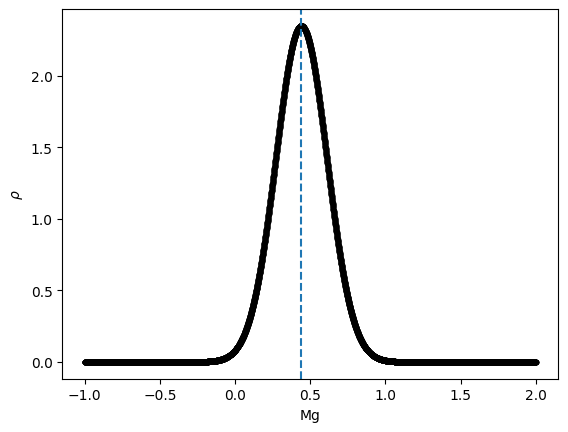

In [14]:
# Generate RC Luminosity Function
mgmin,mgmax = -1., 2.
mg = numpy.linspace(mgmin,mgmax, 10000)
ye = norm.pdf(mg,loc=0.44,scale=0.17)	

zm = interp1d(mg,ye,bounds_error=False,fill_value=(ye[0],ye[-1]))			
gridM_G = mg
gridLF = zm(mg)
gridLF = gridLF#/gridLF.max()

lumfunc = {}
lumfunc['gridM_G'] = gridM_G
lumfunc['gridLF'] = gridLF

# store the luminosity function as a pickle file in tempdir
dtools.picklewrite(lumfunc,'lumfunc_use',tempdir)

cdfval,mgmin,mgmax = dtools.pdf2cdf(ye,xv=mg,getlims=True,usesig=2)

plt.close('all')
plt.plot(mg,ye,'k.')
plt.axvline(0.44,linestyle='--')
plt.xlabel('Mg')
plt.ylabel(r'$\rho$')
plt.savefig(figdir+'/lfrc.png')

#--------------------------------------------------------------